<a href="https://colab.research.google.com/github/bryandaetz1/Apartment_Rent_Prices/blob/master/Apartments_EDA_%26_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [503]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#for histogram and normal probability plot
from scipy.stats import norm   
from scipy import stats

In [504]:
df = pd.read_csv('https://raw.githubusercontent.com/bryandaetz1/Apartment_Rent_Prices/master/apartment_data_clean.csv')

# Exploratory Data Analysis

In [505]:
df.describe()

,Bedrooms,Bathrooms,Zip_Code,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor
count,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.00000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000,8114.000000
mean,1.454400,1.422202,94606.432093,3535.366650,920.733793,0.042149,0.453907,0.583559,0.673774,0.532783,0.907937,0.560143,0.335839,0.572098,0.191891,0.129283,0.078999,0.248459,0.683140,0.431107,0.479049,0.10944,0.518856,0.690535,0.342987,0.206433,0.120039,0.205817,0.280503,0.425068,0.104018,0.124723
std,0.899322,0.562440,429.814280,1401.388031,1624.074355,0.200942,0.497902,0.492999,0.468860,0.498955,0.289133,0.496400,0.472312,0.494805,0.393812,0.335533,0.269754,0.432146,0.465281,0.495261,0.499592,0.31221,0.499675,0.462302,0.474737,0.404770,0.325028,0.404322,0.449273,0.494384,0.305302,0.330425
min,0.000000,0.500000,94014.000000,830.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,94109.000000,2665.000000,650.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,94612.000000,3272.000000,825.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,95110.000000,4075.000000,1071.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,6.000000,5.500000,95148.000000,30000.000000,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Immediately it becomes evident that there are outliers in the dataset.  For instance the max rent is $30,000 and the max square footage is 99,999.  In both cases this is well about the 75th percentile.  

Additionally, it looks like a few of the binary features I extracted from the amenities text have an extremely low or extremely high mean, indicating that the values for these features are predominantly uniform.  For example, Bosch Appliances has a mean of 0.042, Pets Allowed: 0.109, Plank Floor: 0.104, Tile Floor: 0.124, and Laundry: 0.907. These features may not end up being useful to include in the model.  

## Addressing Outliers in Avg_Rent Column

In [506]:
#descriptive statistics for rent grouped by bedroom size
def stat_rent(dataframe):
  rent_averages = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].mean())
  percentile_10 = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].quantile(.10))
  percentile_90 = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].quantile(.90))
  rent_min = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].min())
  rent_max = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].max())
  std = round(df.groupby('Bedrooms', as_index = False)['Avg_Rent'].std())
  count = df.groupby('Bedrooms', as_index = False).size()

  rent_df = pd.DataFrame({'Bedrooms':rent_averages['Bedrooms'],
                        'Average_Rent':rent_averages['Avg_Rent'],
                        '10th_Percentile':percentile_10['Avg_Rent'], 
                        '90th_Percentile':percentile_90['Avg_Rent'],
                        'Minimum':rent_min['Avg_Rent'],
                        'Maximum':rent_max['Avg_Rent'],
                        'Standard_Deviation':std['Avg_Rent'],
                        'Count':count,
                        '% of Dataset':(count/len(df) * 100)})
  return rent_df

stat_rent(df)

,Bedrooms,Average_Rent,10th_Percentile,90th_Percentile,Minimum,Maximum,Standard_Deviation,Count,% of Dataset
0,0,2648.0,1881.0,3335.0,1004,7950,645.0,1065,13.125462
1,1,3076.0,2187.0,4151.0,830,23000,877.0,3265,40.239093
2,2,3993.0,2660.0,5610.0,950,13000,1241.0,3020,37.219620
3,3,4731.0,3095.0,6614.0,1166,20000,1866.0,593,7.308356
4,4,5511.0,3496.0,6540.0,1154,30000,3921.0,143,1.762386
5,5,6308.0,2003.0,11800.0,999,14500,3566.0,23,0.283461
6,6,5041.0,979.0,8300.0,979,9000,3787.0,5,0.061622


The 5 and 6 bedroom listings combined make up less than 0.35% of the dataset and have a high standard deviation, so I elected to remove these listings.

In [507]:
#dropping 5 and 6 bedroom listings
df.drop(df[df['Bedrooms'] > 4].index, axis = 0, inplace = True)

## Addressing Outliers in Avg_Sqft Column

In [508]:
#descriptive statistics for square footage grouped by bedroom size
def stat_sqft(dataframe): 
  sqft_averages = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].mean())
  sqft_10 = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].quantile(.10))
  sqft_90 = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].quantile(.90))
  sqft_min = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].min())
  sqft_max = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].max())
  sqft_std = round(df.groupby('Bedrooms', as_index = False)['Avg_Sqft'].std())
  count = df.groupby('Bedrooms', as_index = False).size()

  sqft_df = pd.DataFrame({'Bedrooms':sqft_averages['Bedrooms'],
                        'Average_Sqft':sqft_averages['Avg_Sqft'],
                        '10th_Percentile':sqft_10['Avg_Sqft'], 
                        '90th_Percentile':sqft_90['Avg_Sqft'],
                        'Minimum':sqft_min['Avg_Sqft'],
                        'Maximum':sqft_max['Avg_Sqft'],
                        'Standard_Deviation':sqft_std['Avg_Sqft'],
                        'Count':count,
                        '% of Dataset':(count/len(df) * 100)})
  return sqft_df

stat_sqft(df)

,Bedrooms,Average_Sqft,10th_Percentile,90th_Percentile,Minimum,Maximum,Standard_Deviation,Count,% of Dataset
0,0,496.0,380.0,608.0,1.0,3181.0,148.0,1065,13.170913
1,1,718.0,540.0,879.0,1.0,7698.0,264.0,3265,40.378432
2,2,1114.0,836.0,1254.0,1.0,99999.0,2555.0,3020,37.348504
3,3,1518.0,1095.0,1846.0,1.0,8695.0,922.0,593,7.333663
4,4,1899.0,1290.0,2741.0,1.0,5113.0,726.0,143,1.768489


Clearly there are some outliers in the square footage column that I'll need to address.  These minimum and maximum values of 1.0 and 99999.0 obviously do not represent actual square footages, so I'm going to further examine them and then replace these incorrect values with the average square footage for the respective bedroom size.

In [509]:
df[df['Avg_Sqft'] < 100]

,Bedrooms,Bathrooms,City,Zip_Code,Neighborhood,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor
1671,1,1.0,Oakland,94609,Hoover-Foster,1725,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1717,1,1.0,Oakland,94610,Westlake,2450,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1761,1,1.0,Alameda,94501,Downtown Alameda,1900,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1771,0,1.0,Berkeley,94704,South Berkeley,1600,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1812,1,1.0,Alameda,94501,West Alameda,1890,1.0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4570,3,1.0,San Francisco,94107,SoMa,2900,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4571,3,1.0,San Francisco,94107,SoMa,2900,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4654,1,1.0,San Francisco,94118,Richmond District,1800,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4669,2,1.0,San Francisco,94110,Mission,4850,1.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4701,0,1.0,San Francisco,94103,SoMa,1100,80.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


Considering the size of apartments in San Francisco, the 80 sqft studio apartment in San Francisco could potentially be a real value, but the other listings with a square footage of 1.0 or 5.0 clearly are not.  I'm going to replace all square footage values of less than 50 with the average sqft value for the respective bedroom size.

In [510]:
# replacing instances where square footage was incorrectly listed as less than 50 with the average square footage for that bedroom size
for i in range (0,5):
  df.loc[(df['Avg_Sqft'] < 50) & (df['Bedrooms'] == i),'Avg_Sqft'] = sqft_df['Average_Sqft'][i]

In [511]:
df[df['Avg_Sqft'] > 9000]

,Bedrooms,Bathrooms,City,Zip_Code,Neighborhood,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor
4920,2,1.0,San Francisco,94118,Lone Mountain,3200,99999.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4921,2,1.0,San Francisco,94134,Visitacion Valley,2950,99999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [512]:
#since the only listings with a sqft > 9000 are 2 bedroom apts, I'll replace those values with the average sqft for a 2 bedroom
df.loc[df['Avg_Sqft'] > 9000, 'Avg_Sqft'] = sqft_df['Average_Sqft'][2]

## Visualizing the Numerical Features

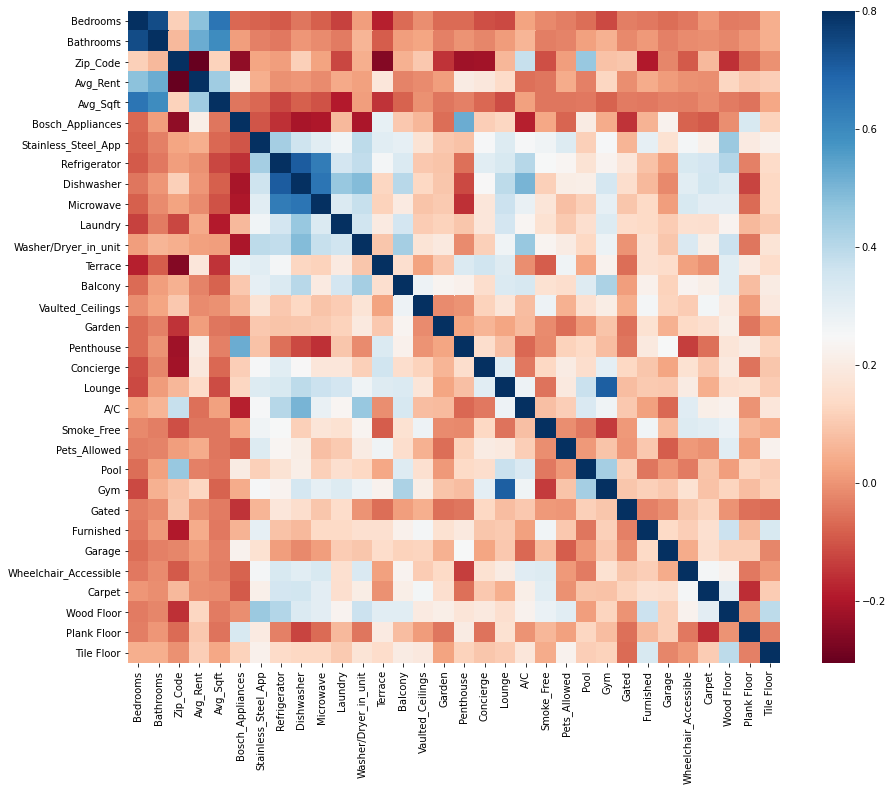

In [513]:
corr_map = df.corr()
f,ax = plt.subplots(figsize = (15,12))
sns.heatmap(corr_map, square = True, vmax = 0.8, cmap = 'RdBu')

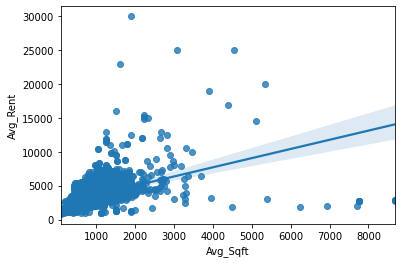

In [514]:
sns.regplot(x = 'Avg_Sqft', y = 'Avg_Rent', data = df)

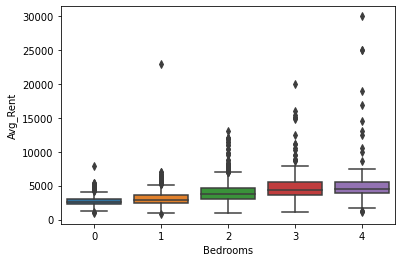

In [515]:
sns.boxplot(x = 'Bedrooms', y = 'Avg_Rent', data = df)

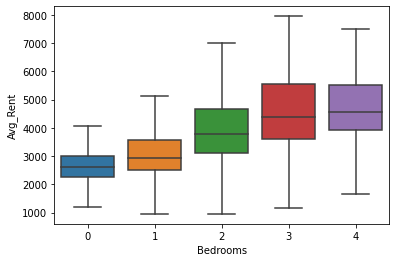

In [516]:
sns.boxplot(x = 'Bedrooms', y = 'Avg_Rent', data = df, showfliers = False)

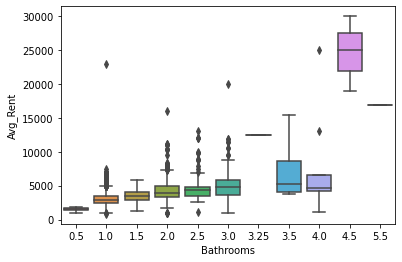

In [517]:
sns.boxplot(x = 'Bathrooms', y = 'Avg_Rent', data = df)

It looks like there are still a number of outliers that it may prove beneficial to remove.  I'm going to use the functions I created earlier to view descriptive statistics for rent and square footage by bedroom size to get a sense of how to address the remaining outliers.

In [518]:
stat_rent(df)

,Bedrooms,Average_Rent,10th_Percentile,90th_Percentile,Minimum,Maximum,Standard_Deviation,Count,% of Dataset
0,0,2648.0,1881.0,3335.0,1004,7950,645.0,1065,13.170913
1,1,3076.0,2187.0,4151.0,830,23000,877.0,3265,40.378432
2,2,3993.0,2660.0,5610.0,950,13000,1241.0,3020,37.348504
3,3,4731.0,3095.0,6614.0,1166,20000,1866.0,593,7.333663
4,4,5511.0,3496.0,6540.0,1154,30000,3921.0,143,1.768489


In [519]:
stat_sqft(df)

,Bedrooms,Average_Sqft,10th_Percentile,90th_Percentile,Minimum,Maximum,Standard_Deviation,Count,% of Dataset
0,0,497.0,380.0,608.0,80.0,3181.0,146.0,1065,13.170913
1,1,720.0,540.0,879.0,100.0,7698.0,261.0,3265,40.378432
2,2,1052.0,839.0,1254.0,500.0,5381.0,207.0,3020,37.348504
3,3,1536.0,1095.0,1846.0,598.0,8695.0,907.0,593,7.333663
4,4,1912.0,1300.0,2741.0,800.0,5113.0,708.0,143,1.768489


There are definitely still some outliers present.  Choosing to elimnate the top 0.5% of rent and square footage values to address this.

In [520]:
df.drop(df.loc[(df['Avg_Rent'] > df['Avg_Rent'].quantile(.995)) | (df['Avg_Sqft'] > df['Avg_Sqft'].quantile(.995))].index, axis = 0, inplace = True)
df.shape

(8016, 34)

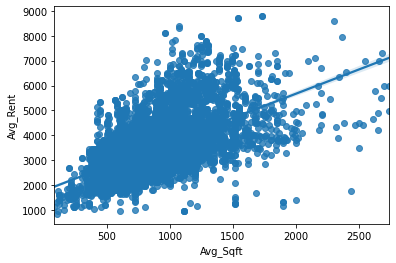

In [521]:
sns.regplot(x = 'Avg_Sqft', y = 'Avg_Rent', data = df)

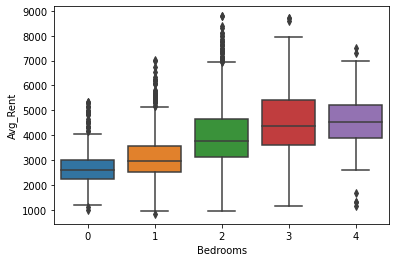

In [522]:
sns.boxplot(x = 'Bedrooms', y = 'Avg_Rent', data = df)

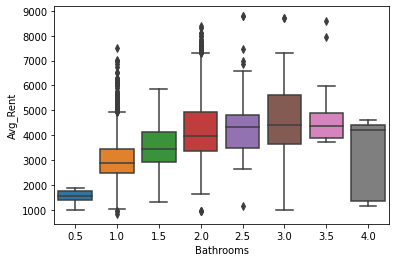

In [523]:
sns.boxplot(x = 'Bathrooms', y = 'Avg_Rent', data = df)

## Examining Categorical Features (City, Zip_Code, and Neighborhood)



In [524]:
df.dtypes

Bedrooms                   int64
Bathrooms                float64
City                      object
Zip_Code                   int64
Neighborhood              object
Avg_Rent                   int64
Avg_Sqft                 float64
Bosch_Appliances           int64
Stainless_Steel_App        int64
Refrigerator               int64
Dishwasher                 int64
Microwave                  int64
Laundry                    int64
Washer/Dryer_in_unit       int64
Terrace                    int64
Balcony                    int64
Vaulted_Ceilings           int64
Garden                     int64
Penthouse                  int64
Concierge                  int64
Lounge                     int64
A/C                        int64
Smoke_Free                 int64
Pets_Allowed               int64
Pool                       int64
Gym                        int64
Gated                      int64
Furnished                  int64
Garage                     int64
Wheelchair_Accessible      int64
Carpet    

In [525]:
pd.DataFrame({'Value Counts':df.City.value_counts(),
              '% of Sample Size':(df.City.value_counts() / len(df)) * 100})

,Value Counts,% of Sample Size
San Francisco,2947,36.763972
San Jose,2238,27.919162
Oakland,1608,20.059880
Milpitas,331,4.129242
Berkeley,205,2.557385
Santa Clara,169,2.108283
Campbell,141,1.758982
Emeryville,113,1.409681
Cupertino,105,1.309880
Alameda,59,0.736028


There are a number of cities that appear infrequently.  I've elected to consilidate these into an 'Other' category.

In [526]:
#consolidating cities that appear infrequently into one group
df['City_Clean'] = df['City'].apply(lambda x: 'Other' if x in ['Santa Clara', 
                                                                 'Campbell', 
                                                                 'Emeryville', 
                                                                 'Cupertino', 
                                                                 'Alameda',
                                                                 'Daly City',
                                                                 'San Leandro',
                                                                 'Sunnyvale',
                                                                 'Los Gatos',
                                                                 'Piedmont',
                                                                 'Saratoga'] else x)

In [527]:
df['City_Clean'].unique()

array(['Oakland', 'Other', 'Berkeley', 'San Francisco', 'San Jose',
       'Milpitas'], dtype=object)

In [528]:
df['Neighborhood'].nunique()

337

In [529]:
df['Zip_Code'].nunique()

89

After examining the number of unique values per city for both Neighborhood and Zip_Code, it looks like Zip Code is going to be a more useful feature for our model.  Since zip code and neighhorhood convey very similar information, and there are so many different neighborhood values for each city, I would be introducing unneccesary scarcity into the dataset by creating dummy variables for both features.  I think it's going to be more effective here to just use the Zip Code feature.



In [530]:
zip_codes = pd.DataFrame({'Value Counts':df.Zip_Code.value_counts(),
                          '% of Sample Size':(df.Zip_Code.value_counts() / len(df)) * 100})
zip_codes

,Value Counts,% of Sample Size
94612,908,11.327345
94107,589,7.347804
94105,540,6.736527
94103,522,6.511976
95035,331,4.129242
...,...,...
94127,2,0.024950
94710,1,0.012475
95139,1,0.012475
95070,1,0.012475


In [531]:
zip_codes[zip_codes['% of Sample Size'] > 3]

,Value Counts,% of Sample Size
94612,908,11.327345
94107,589,7.347804
94105,540,6.736527
94103,522,6.511976
95035,331,4.129242
95134,291,3.630240
95110,289,3.605289
95126,271,3.380739
94102,265,3.305888


In [532]:
#getting a list of zip codes that make up less than 3% of sample size
zip_list = zip_codes[zip_codes['% of Sample Size'] < 3].index.tolist()

In [533]:
#creating a new feature where for zip codes that appear in less than 3% of the sample size, the zip code is replaced by 'City - other' where City represents the city
df['Zip_Code_Clean'] = df.apply(lambda x: str(x['City_Clean'] + '-other') if x['Zip_Code'] in zip_list else x['Zip_Code'], axis = 1)

In [534]:
#making sure this worked as expected
df[['City_Clean','Zip_Code','Zip_Code_Clean']].loc[df['Zip_Code_Clean'] != df['Zip_Code']]

,City_Clean,Zip_Code,Zip_Code_Clean
0,Oakland,94609,Oakland-other
1,Oakland,94609,Oakland-other
2,Oakland,94609,Oakland-other
3,Oakland,94609,Oakland-other
4,Oakland,94609,Oakland-other
...,...,...,...
8109,San Jose,95136,San Jose-other
8110,San Jose,95132,San Jose-other
8111,San Jose,95112,San Jose-other
8112,San Jose,95128,San Jose-other


##Visualizing Categorical Features

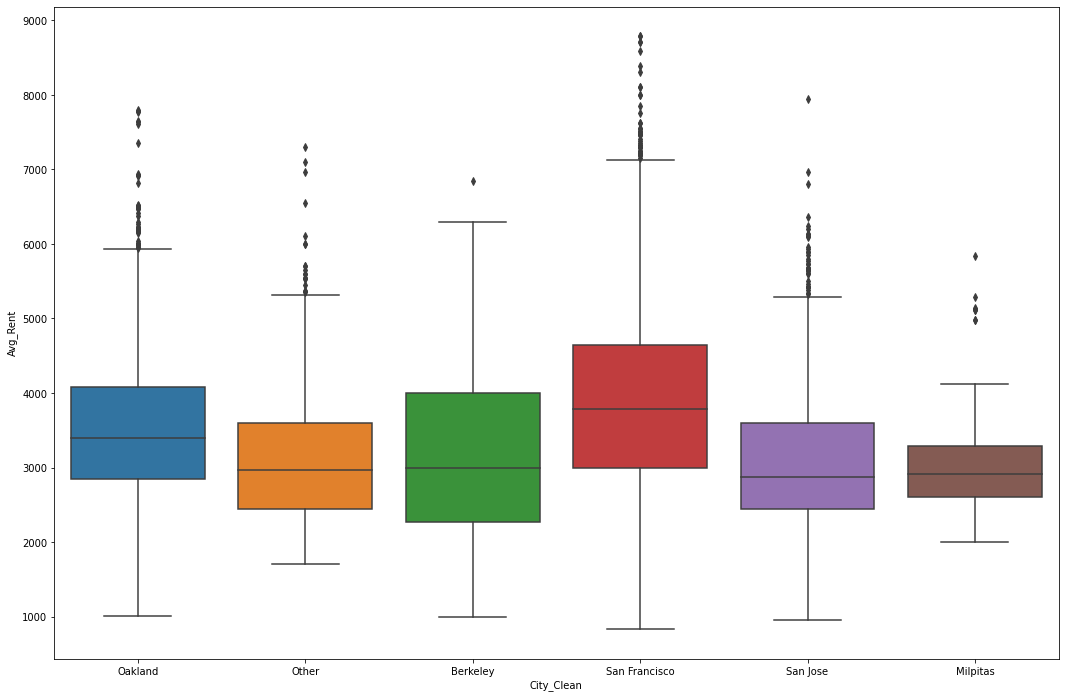

In [535]:
f,ax = plt.subplots(figsize = (18,12))
sns.boxplot(x = 'City_Clean', y = 'Avg_Rent', data = df)

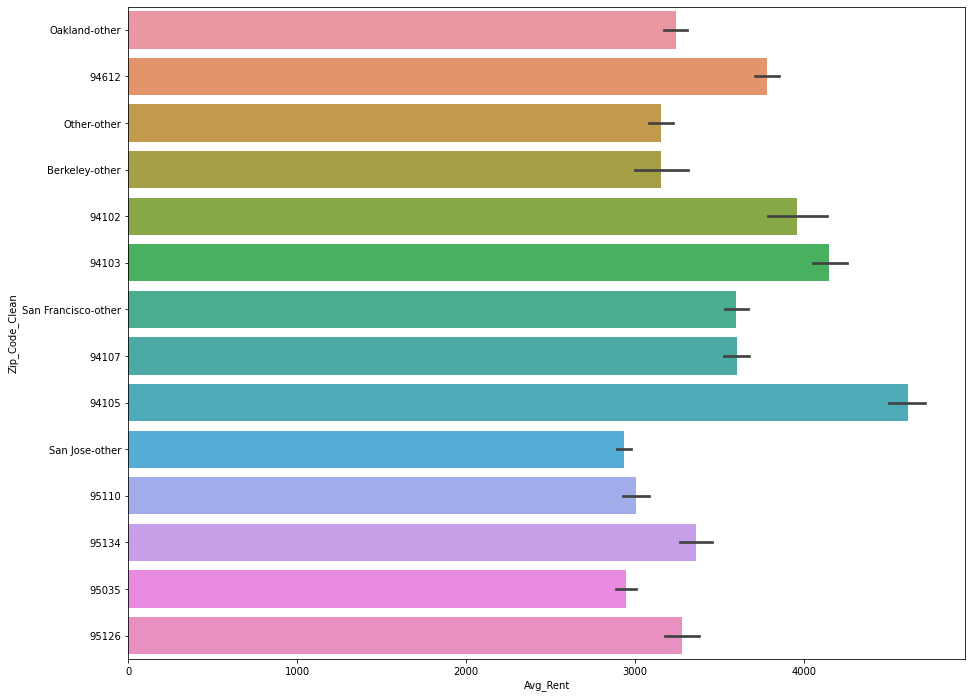

In [536]:
f,ax = plt.subplots(figsize = (15,12))
sns.barplot(x = 'Avg_Rent', y = 'Zip_Code_Clean', data = df, orient = 'h')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

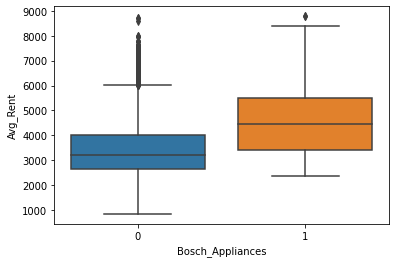

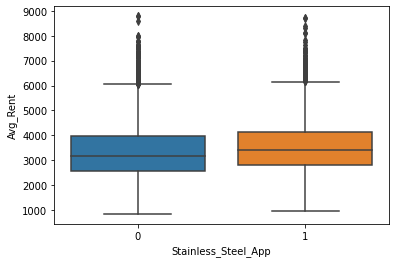

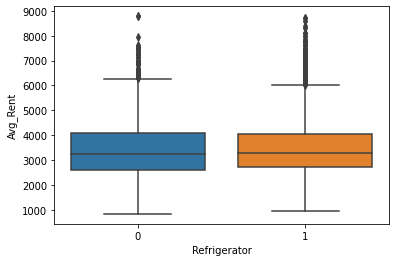

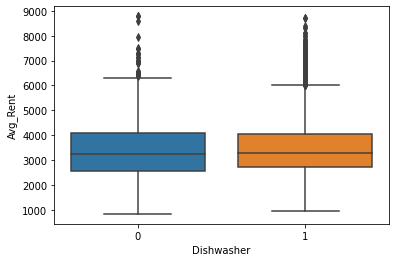

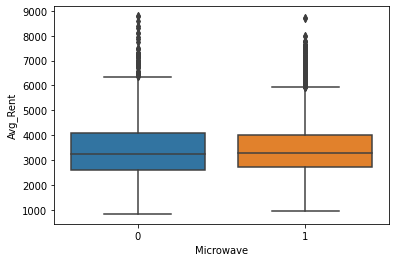

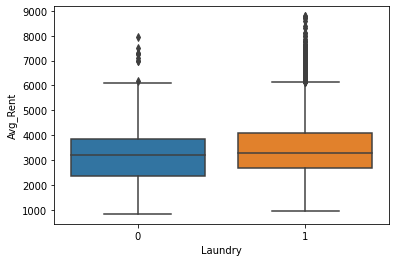

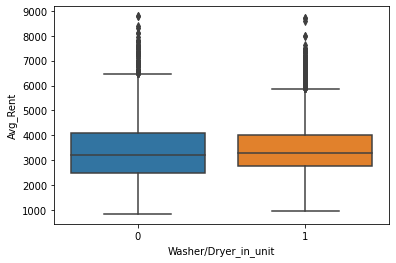

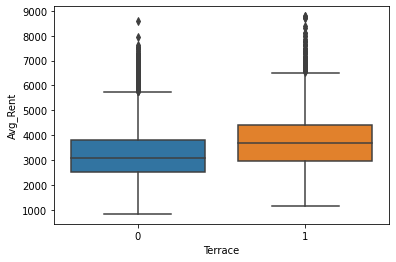

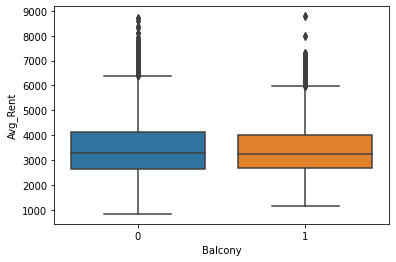

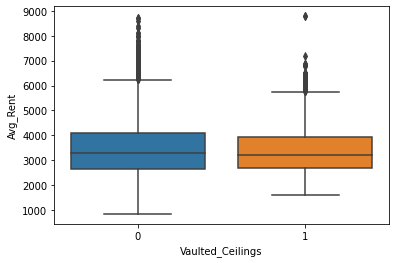

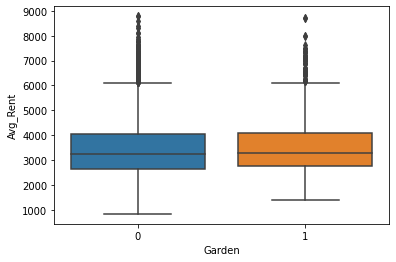

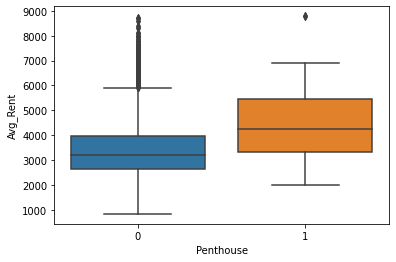

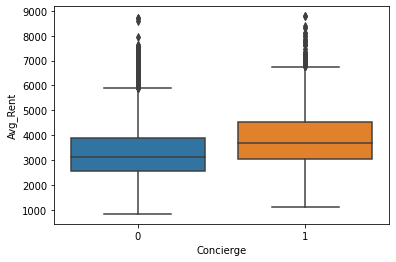

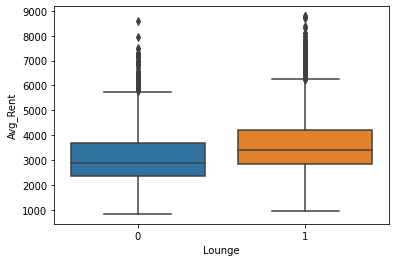

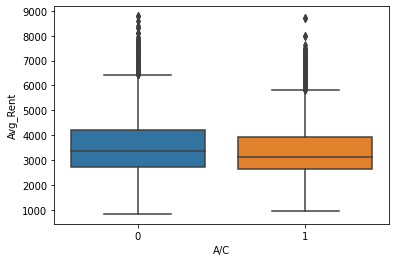

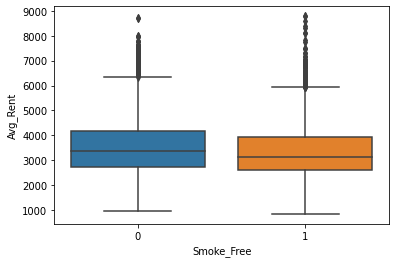

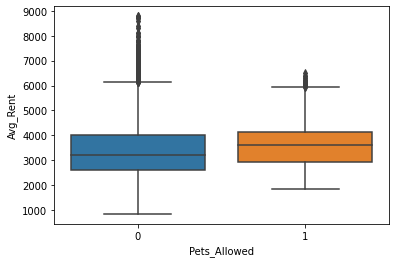

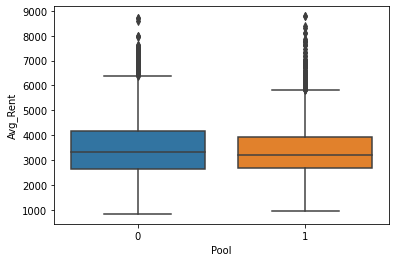

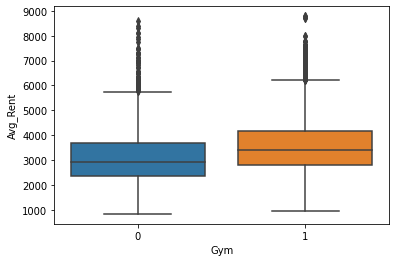

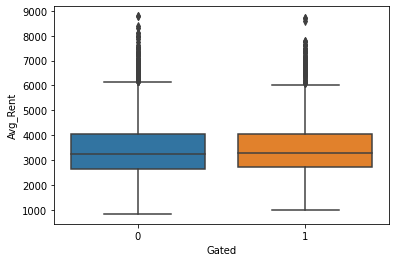

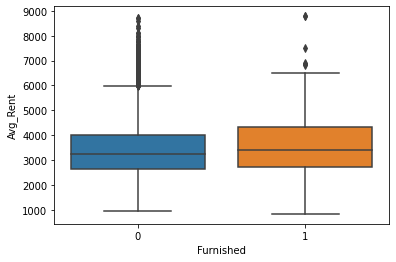

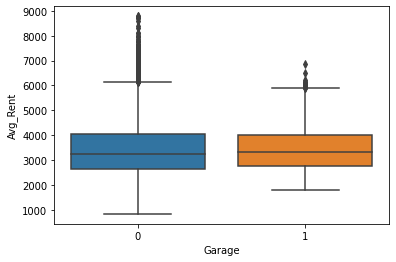

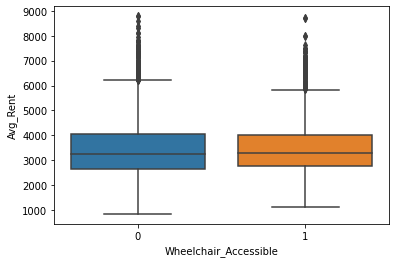

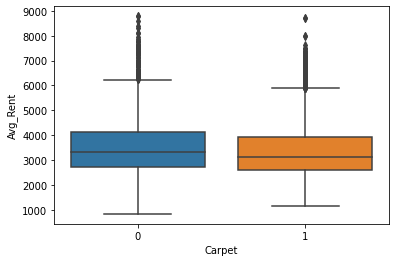

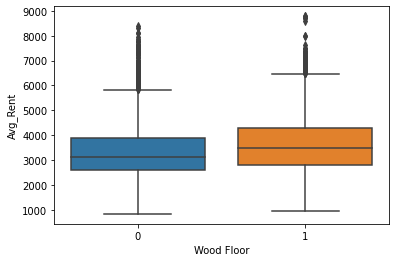

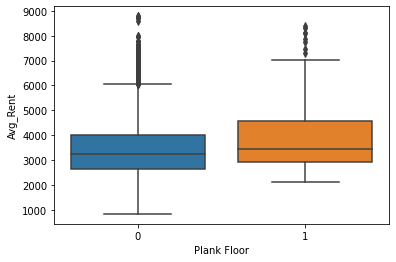

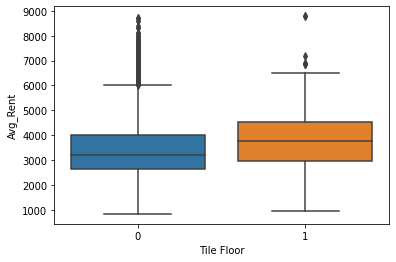

In [599]:
#plotting binary features
for i in df.columns[7:-2]:
  plt.figure()
  sns.boxplot(x = i, y = 'Avg_Rent', data = df)

## Creating Dummy Variables for Multi-valued Categorical Features

In [538]:
df.columns

Index(['Bedrooms', 'Bathrooms', 'City', 'Zip_Code', 'Neighborhood', 'Avg_Rent',
       'Avg_Sqft', 'Bosch_Appliances', 'Stainless_Steel_App', 'Refrigerator',
       'Dishwasher', 'Microwave', 'Laundry', 'Washer/Dryer_in_unit', 'Terrace',
       'Balcony', 'Vaulted_Ceilings', 'Garden', 'Penthouse', 'Concierge',
       'Lounge', 'A/C', 'Smoke_Free', 'Pets_Allowed', 'Pool', 'Gym', 'Gated',
       'Furnished', 'Garage', 'Wheelchair_Accessible', 'Carpet', 'Wood Floor',
       'Plank Floor', 'Tile Floor', 'City_Clean', 'Zip_Code_Clean'],
      dtype='object')

In [539]:
#dropping Zip_Code and Neighborhood columns and creating new dataframe with dummy variables for City and Zip_Code_Clean columns
df_new = pd.get_dummies(data = df.drop(['Zip_Code','Neighborhood','City'], axis = 1), columns = ['City_Clean','Zip_Code_Clean'], drop_first = False)

In [540]:
df_new.head()

,Bedrooms,Bathrooms,Avg_Rent,Avg_Sqft,Bosch_Appliances,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor,City_Clean_Berkeley,City_Clean_Milpitas,City_Clean_Oakland,City_Clean_Other,City_Clean_San Francisco,City_Clean_San Jose,Zip_Code_Clean_94102,Zip_Code_Clean_94103,Zip_Code_Clean_94105,Zip_Code_Clean_94107,Zip_Code_Clean_94612,Zip_Code_Clean_95035,Zip_Code_Clean_95110,Zip_Code_Clean_95126,Zip_Code_Clean_95134,Zip_Code_Clean_Berkeley-other,Zip_Code_Clean_Oakland-other,Zip_Code_Clean_Other-other,Zip_Code_Clean_San Francisco-other,Zip_Code_Clean_San Jose-other
0,1,1.0,2935,502.0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1.0,2875,502.0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,1.0,2875,502.0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,1.0,2875,502.0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,1.0,2875,502.0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


To prevent multicollinearity I'll now need to drop the zip code columns where there is only one zip code for the city.

In [541]:
#getting list of zip codes that appear for each city
zip_dict = {'San Francisco': [],
             'San Jose': [],
             'Oakland': [],
             'Milpitas':[],
             'Berkeley':[],
             'Other':[]}
for city in df['City_Clean'].unique():
  zip_dict[city].append(df.loc[df['City_Clean'] == city,'Zip_Code_Clean'].unique().tolist())

zip_dict

{'Berkeley': [['Berkeley-other']],
 'Milpitas': [[95035]],
 'Oakland': [['Oakland-other', 94612]],
 'Other': [['Other-other']],
 'San Francisco': [[94102, 94103, 'San Francisco-other', 94107, 94105]],
 'San Jose': [['San Jose-other', 95110, 95134, 95126]]}

In [542]:
# also decided to drop the Bosch_Appliances feature since the vast majority of samples have a value of 0
df_new.drop(['Zip_Code_Clean_Berkeley-other','Zip_Code_Clean_95035','Zip_Code_Clean_Other-other', 'Bosch_Appliances'], axis = 1, inplace = True)

In [543]:
df_new.head()

,Bedrooms,Bathrooms,Avg_Rent,Avg_Sqft,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor,City_Clean_Berkeley,City_Clean_Milpitas,City_Clean_Oakland,City_Clean_Other,City_Clean_San Francisco,City_Clean_San Jose,Zip_Code_Clean_94102,Zip_Code_Clean_94103,Zip_Code_Clean_94105,Zip_Code_Clean_94107,Zip_Code_Clean_94612,Zip_Code_Clean_95110,Zip_Code_Clean_95126,Zip_Code_Clean_95134,Zip_Code_Clean_Oakland-other,Zip_Code_Clean_San Francisco-other,Zip_Code_Clean_San Jose-other
0,1,1.0,2935,502.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1.0,2875,502.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1.0,2875,502.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,1.0,2875,502.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1.0,2875,502.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Examining Distribution of Avg_Rent and Avg_Sqft Columns

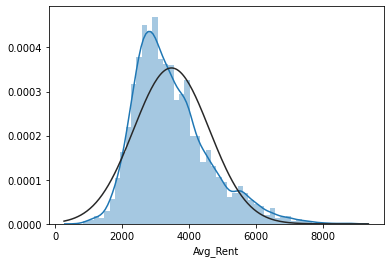

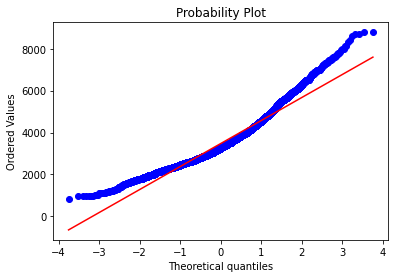

In [544]:
#histogram and normal probability plot for rent
sns.distplot(df_new['Avg_Rent'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_new['Avg_Rent'], plot=plt)

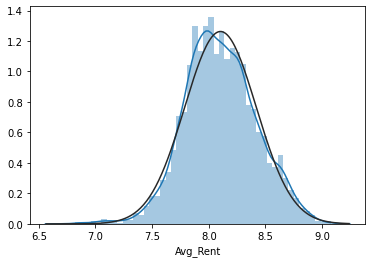

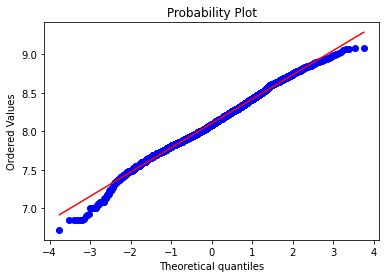

In [545]:
#histogram and normal probability plot for log of rent
sns.distplot(np.log(df_new['Avg_Rent']), fit = norm);
fig = plt.figure()
res = stats.probplot(np.log(df_new['Avg_Rent']), plot=plt)

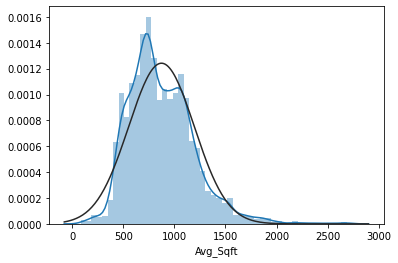

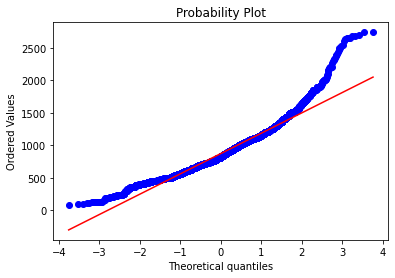

In [546]:
#histogram and normal probability plot for square footage
sns.distplot(df_new['Avg_Sqft'], fit = norm);
fig = plt.figure()
res = stats.probplot(df_new['Avg_Sqft'], plot=plt)

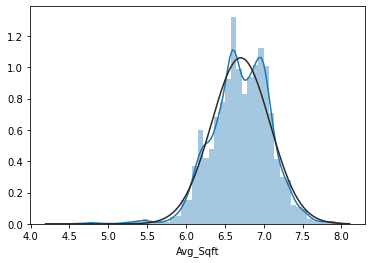

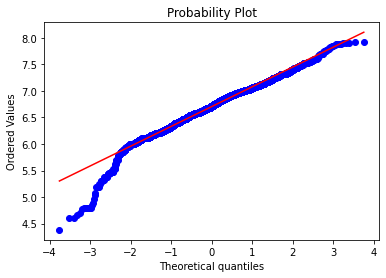

In [547]:
#histogram and normal probability plot for log of square footage
sns.distplot(np.log(df_new['Avg_Sqft']), fit = norm)
fig = plt.figure()
res = stats.probplot(np.log(df_new['Avg_Sqft']), plot = plt)

In [548]:
#taking log of Avg_Rent and Avg_Sqft columns
df_new['Avg_Rent'] = np.log(df_new['Avg_Rent'])
df_new['Avg_Sqft'] = np.log(df_new['Avg_Sqft'])

# Model Building

In [549]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [550]:
X = df_new.drop(['Avg_Rent'], axis = 1)
y = df_new['Avg_Rent']

In [551]:
X.head()

,Bedrooms,Bathrooms,Avg_Sqft,Stainless_Steel_App,Refrigerator,Dishwasher,Microwave,Laundry,Washer/Dryer_in_unit,Terrace,Balcony,Vaulted_Ceilings,Garden,Penthouse,Concierge,Lounge,A/C,Smoke_Free,Pets_Allowed,Pool,Gym,Gated,Furnished,Garage,Wheelchair_Accessible,Carpet,Wood Floor,Plank Floor,Tile Floor,City_Clean_Berkeley,City_Clean_Milpitas,City_Clean_Oakland,City_Clean_Other,City_Clean_San Francisco,City_Clean_San Jose,Zip_Code_Clean_94102,Zip_Code_Clean_94103,Zip_Code_Clean_94105,Zip_Code_Clean_94107,Zip_Code_Clean_94612,Zip_Code_Clean_95110,Zip_Code_Clean_95126,Zip_Code_Clean_95134,Zip_Code_Clean_Oakland-other,Zip_Code_Clean_San Francisco-other,Zip_Code_Clean_San Jose-other
0,1,1.0,6.2186,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1.0,6.2186,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1.0,6.2186,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,1.0,6.2186,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1.0,6.2186,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [552]:
y.head()

0    7.984463
1    7.963808
2    7.963808
3    7.963808
4    7.963808
Name: Avg_Rent, dtype: float64

In [553]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 24)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 24)

## Linear Regression

In [554]:
mlr = linear_model.LinearRegression()

mlr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [555]:
pred_mlr = mlr.predict(X_valid)

In [556]:
#calculating RMSE (root mean square error)
print('RSME:', np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(pred_mlr))))

#calculating R^2 score
r2_mlr = r2_score(np.exp(y_valid), np.exp(pred_mlr))
print('R^2 Score:', r2_mlr)

#calculating adjusted R^2 score
n = len(X_train)    #number of observations in sample
p = len(X_train.columns) # number of independent variables

print('Adjusted R^2 Score:', 1 - (1 - r2_mlr) * ((n-1)/(n-p-1)))

RSME: 587.1473283590561
R^2 Score: 0.7417677230573131
Adjusted R^2 Score: 0.7391055346352235


## Support Vector Machine (SVM)

In [557]:
svm = SVR()

svm.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [558]:
pred_svm = svm.predict(X_valid)

In [559]:
#calculating RMSE
print('RSME:', np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(pred_svm))))

#calculating R^2 score
r2_svm = r2_score(np.exp(y_valid), np.exp(pred_svm))
print('R^2 Score:', r2_svm)

#calculating adjusted R^2 score
n = len(X_train)    #number of observations in sample
p = len(X_train.columns) # number of independent variables

print('Adjusted R^2 Score:', 1 - (1 - r2_svm) * ((n-1)/(n-p-1)))

RSME: 469.0777521505111
R^2 Score: 0.8351814773340677
Adjusted R^2 Score: 0.8334823173065838


## Random Forest

In [560]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 24)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=24, verbose=0, warm_start=False)

In [561]:
pred_rf = rf.predict(X_valid)

In [562]:
#calculating RMSE
print('RSME:', np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(pred_rf))))

#calculating R^2 score
r2_rf = r2_score(np.exp(y_valid), np.exp(pred_rf))
print('R^2 Score:', r2_rf)


#calculating adjusted R^2 score
print('Adjusted R^2 Score:', 1 - (1 - r2_rf) * ((n-1)/(n-p-1)))

RSME: 399.25059444672337
R^2 Score: 0.8805991305334159
Adjusted R^2 Score: 0.8793681937347912


## XGBoost

In [563]:
xgb = XGBRegressor(random_state = 24)

xgb.fit(X_train, y_train)

[21:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=24,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [564]:
pred_xgb = xgb.predict(X_valid)

In [565]:
#calculating RMSE
print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_valid), np.exp(pred_xgb))))

#calculating R^2
r2_xgb = r2_score(np.exp(y_valid), np.exp(pred_xgb))
print('R^2 Score:', r2_xgb)

#calculating adjusted R^2 score
print('Adjusted R^2 Score:', 1 - (1 - r2_xgb) * ((n-1)/(n-p-1)))

RMSE: 541.0989638350195
R^2 Score: 0.7806842855141455
Adjusted R^2 Score: 0.7784232987668687


## Comparing Models

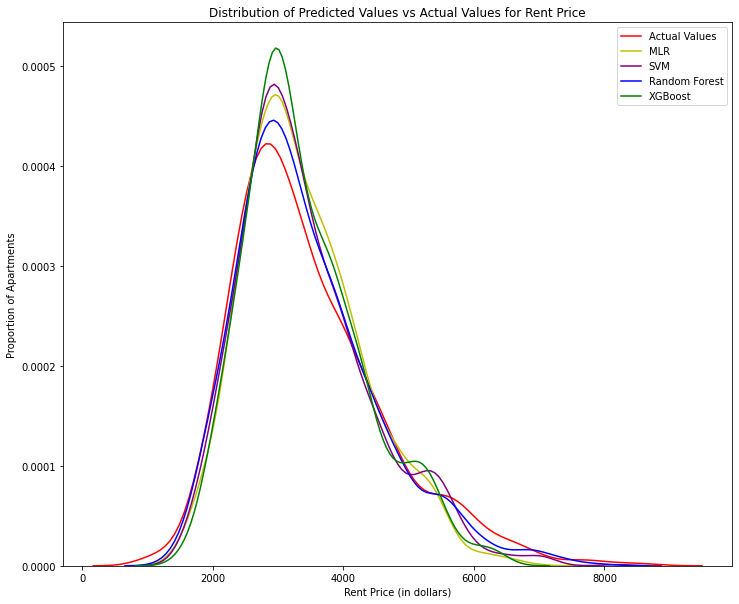

In [566]:
# visualizing distribution of predicted values vs actual values for rent
plt.figure(figsize = (12,10))

ax1 = sns.distplot(np.exp(y_valid), hist = False, color = 'r', label = 'Actual Values')
ax2 = sns.distplot(np.exp(pred_mlr), hist = False, color = 'y', label = 'MLR')
ax3 = sns.distplot(np.exp(pred_svm), hist = False, color = 'purple', label = 'SVM')
ax4 = sns.distplot(np.exp(pred_rf), hist = False, color = 'b', label = 'Random Forest')
ax5 = sns.distplot(np.exp(pred_xgb), hist = False, color = 'g', label = 'XGBoost')


plt.title('Distribution of Predicted Values vs Actual Values for Rent Price')
plt.xlabel('Rent Price (in dollars)')
plt.ylabel('Proportion of Apartments')

plt.show()
plt.close()

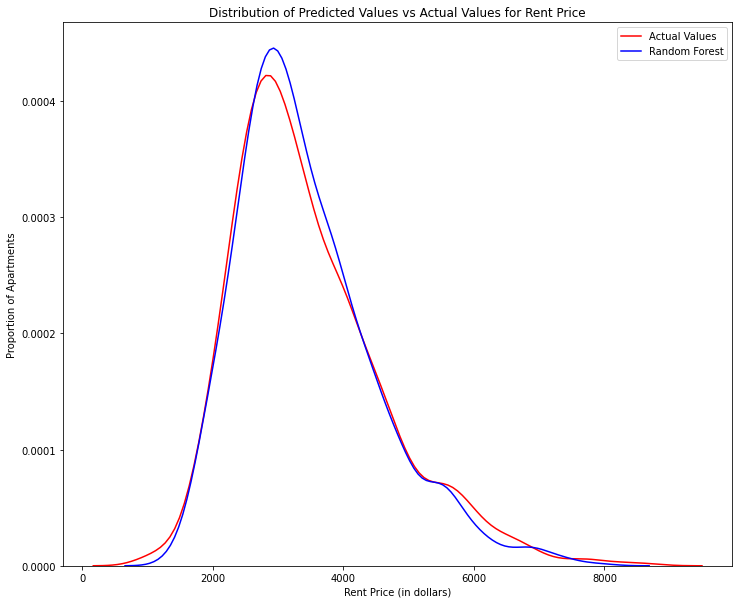

In [567]:
#taking a closer look at just the distribution of predictions for the RF model compared to the actual values
plt.figure(figsize = (12,10))

ax1 = sns.distplot(np.exp(y_valid), hist = False, color = 'r', label = 'Actual Values')
ax2 = sns.distplot(np.exp(pred_rf), hist = False, color = 'b', label = 'Random Forest')

plt.title('Distribution of Predicted Values vs Actual Values for Rent Price')
plt.xlabel('Rent Price (in dollars)')
plt.ylabel('Proportion of Apartments')

plt.show()
plt.close()

In [598]:
# comparing actual values to predictions from the different models for the first 20 samples
pd.DataFrame({'Actual Values':np.exp(y_valid).head(20),
              'Linear Regression':np.around(np.exp(pred_mlr[:20]).tolist()),
              'Support Vector Machine':np.around(np.exp(pred_svm[:20]).tolist()),
              'Random Forest':np.around(np.exp(pred_rf[:20]).tolist()),
              'XGBoost':np.around(np.exp(pred_xgb[:20]).tolist())})

,Actual Values,Linear Regression,Support Vector Machine,Random Forest,XGBoost
8083,1850.0,1772.0,1724.0,1882.0,1895.0
5570,2695.0,2794.0,2753.0,2728.0,2840.0
5567,2644.0,2717.0,2680.0,2618.0,2801.0
5947,2462.0,2652.0,2707.0,2572.0,2916.0
7284,1950.0,2333.0,2138.0,2013.0,2398.0
2662,2795.0,3636.0,3126.0,3177.0,3588.0
152,2876.0,2889.0,3029.0,3112.0,2896.0
2186,3721.0,3257.0,3359.0,3619.0,3383.0
3948,4295.0,3997.0,4144.0,4170.0,3858.0
5482,3119.0,3787.0,3347.0,3097.0,3313.0


## Examining Feature Importances for Best Model (Random Forest)


In [568]:
#getting feature importances
feature_importances = ({'Name':[],
                        'Score':[]})

for name, score in zip(X.columns, rf.feature_importances_):
  feature_importances['Name'].append(name)
  feature_importances['Score'].append(score)

feature_importances = pd.DataFrame(feature_importances).sort_values(['Score'], ascending = False)

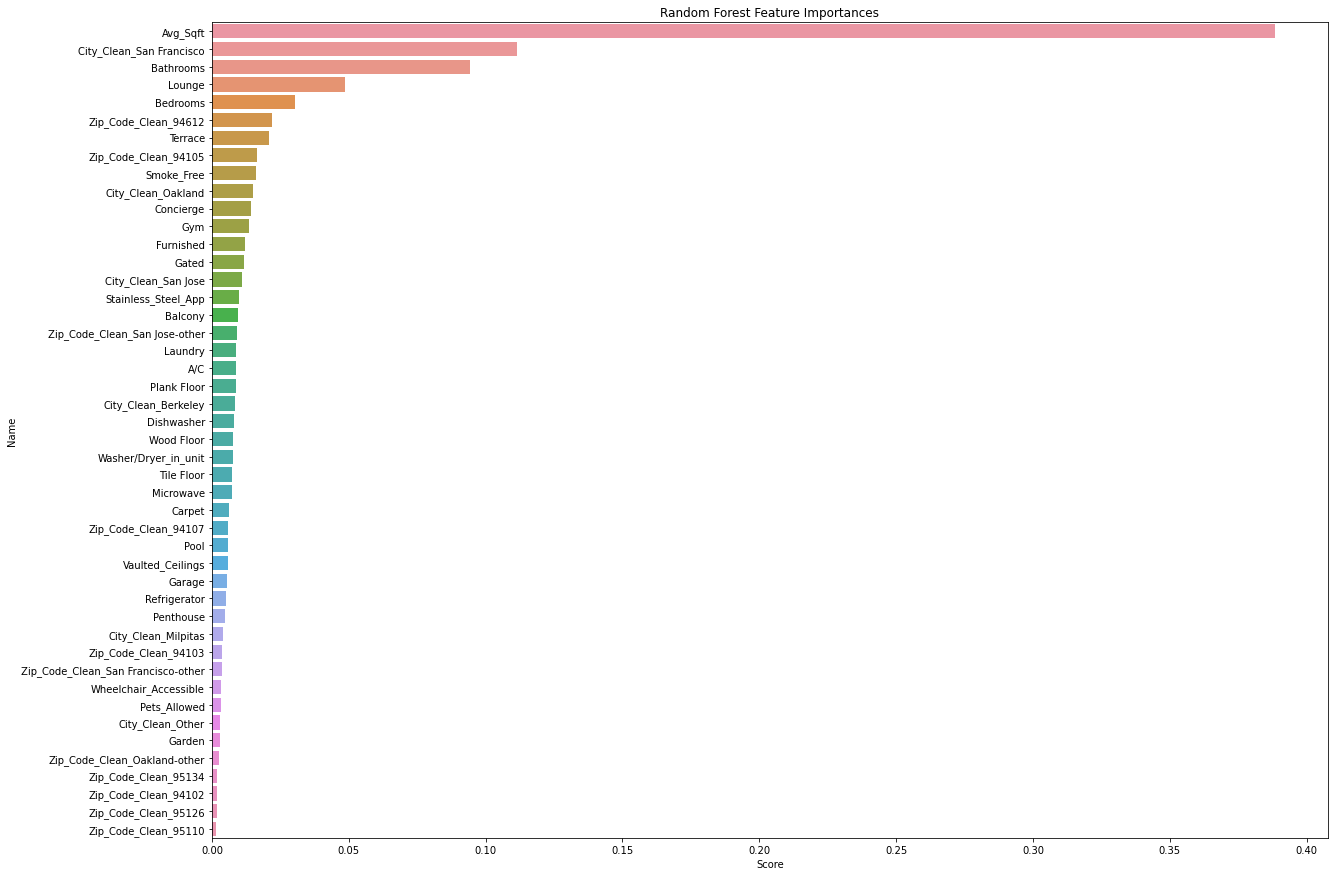

In [569]:
#plotting feature importances
f, ax = plt.subplots(figsize = (20,15))
sns.barplot(x = 'Score', y = 'Name', data = feature_importances, orient = "h")
plt.title('Random Forest Feature Importances')
plt.show()